In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dyflownet as dfn

## Merging Network

source 0 -> link 0 -> sink 0

source 1 -> sink 0

In [2]:
num_x_grid, num_y_grid = 26, 26

initial_condition = dfn.utils.generate_boundary_combos(np.linspace(0, 5, num_x_grid), np.linspace(0, 5, num_y_grid))

state_len = len(initial_condition[0, :])


net_0 = dfn.net.Network(ID = 'net_0', state_len = state_len, num_step = 10000, time_step_size = 0.01)


source_0 = dfn.cell.Source(ID = 'source_0', initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.6),
                           sending = dfn.flow.BufferSendingFlow(demand=0.6, capacity=1, ignore_queue=True))

source_1 = dfn.cell.Source(ID = 'source_1', initial_condition={'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.4),
                           sending = dfn.flow.BufferSendingFlow(demand=0.4, capacity=1, ignore_queue=True))

link_0 = dfn.cell.Link(ID = 'link_0', max_density = 5, max_speed = 1, initial_condition = {'density': initial_condition[0, :]},
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       sending = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1))

sink_0 = dfn.cell.Sink(ID = 'sink_0', max_density = 5, max_speed = 1, initial_condition = {'density': initial_condition[1, :]}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=6, capacity=np.inf),
                       boundary_outflow = dfn.flow.BoundaryOutflow(boundary_speed=1, boundary_capacity=1))

junction_0 = dfn.node.BasicJunction(ID = 'node_0', incoming_cell_list = [source_0], outgoing_cell_list = [link_0])

junction_1 = dfn.node.TwoToOneMergeJunction(ID = 'node_1', merging_priority = [1, 1], 
                                            incoming_cell_list = [link_0, source_1], outgoing_cell_list = [sink_0])


# Add sources.
net_0.add_cell('source', source_0)
net_0.add_cell('source', source_1)

# Add links.
net_0.add_cell('link', link_0)

# Add sinks.
net_0.add_cell('sink', sink_0)

# Add nodes.
net_0.add_node(junction_0)
net_0.add_node(junction_1)

# Run.
net_0.run()

source_0 initialized.
source_1 initialized.
link_0 initialized.
sink_0 initialized.
node_0 initialized.
node_1 initialized.
time cost: 4.0 seconds.


In [3]:
X, Y = np.meshgrid(np.linspace(0, 5, num_x_grid), np.linspace(0, 5, num_y_grid), indexing='ij')

X = X.flatten()
Y = Y.flatten()

vc_len = len(X)

sending_source_0 = source_0.flow_dict['sending'].compute_flow(vc_len)

receiving_link_0 = link_0.flow_dict['receiving'].compute_flow(X)
sending_link_0 = link_0.flow_dict['sending'].compute_flow(X)

sending_source_1 = source_1.flow_dict['sending'].compute_flow(vc_len)

receiving_sink_0 = sink_0.flow_dict['receiving'].compute_flow(Y)
outflow_sink_0 = sink_0.flow_dict['boundary_outflow'].compute_flow(Y)

inter_cell_flow_0 = junction_0.compute_inter_cell_flow(vc_len, [sending_source_0], [receiving_link_0])[:, 0, 0]

inter_cell_flow_1 = junction_1.compute_inter_cell_flow(vc_len, [sending_link_0, sending_source_1], [receiving_sink_0])[:, 0, 0]
inter_cell_flow_2 = junction_1.compute_inter_cell_flow(vc_len, [sending_link_0, sending_source_1], [receiving_sink_0])[:, 1, 0]

U = inter_cell_flow_0 - inter_cell_flow_1
V = inter_cell_flow_1 + inter_cell_flow_2 - outflow_sink_0

norm = np.sqrt(U**2 + V**2)

U_normed = np.divide(U, norm, out=np.zeros_like(U), where=norm!=0)
V_normed = np.divide(V, norm, out=np.zeros_like(V), where=norm!=0)

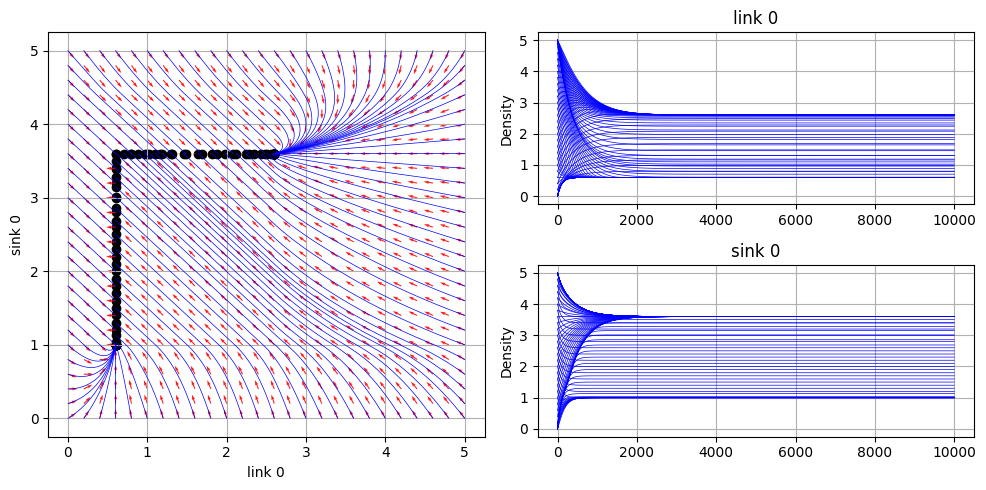

In [4]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.scatter(link_0.state_output['density'][:, -1], sink_0.state_output['density'][:, -1], color='k')
plt.plot(link_0.state_output['density'].T, sink_0.state_output['density'].T,  'b', linewidth=0.5)
plt.quiver(X, Y, U_normed, V_normed, color='red', alpha=0.9)
plt.xlabel('link 0')
plt.ylabel('sink 0')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(link_0.state_output['density'].T, 'b', linewidth=0.5)
plt.title('link 0')
plt.ylabel('Density')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(sink_0.state_output['density'].T, 'b', linewidth=0.5)
plt.title('sink 0')
plt.ylabel('Density')
plt.grid()

plt.tight_layout()

plt.show()